In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

from midvoxio.voxio import vox_to_arr

In [2]:
blood_mask = vox_to_arr('../experiment_files/images/blood.vox')
myocardium_mask = vox_to_arr('../experiment_files/images/myocardium.vox')
blood_mask = np.where(np.sum(blood_mask, axis=-1) > 0, 1, 0)
myocardium_mask = np.where(np.sum(myocardium_mask, axis=-1) > 0, 1, 0)

In [3]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
                               matrix_dims = (256,256,256),
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1592, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

test_phantom.add_tissue(fat, mask=np.ones((256,256,256)))
test_phantom.add_tissue(myocardium, mask=myocardium_mask)
test_phantom.add_tissue(blood, mask=blood_mask)
test_phantom.set_default_tissue('fat')
# plt.imshow(test_phantom.get_complete()[0,:,:,80])
# test_phantom.save('../experiment_files/cardiac_phantom')
# utils.save_mrc(test_phantom.get_complete(), '../experiment_files/cardiac_phantom/cardiac_phantom.mrc')

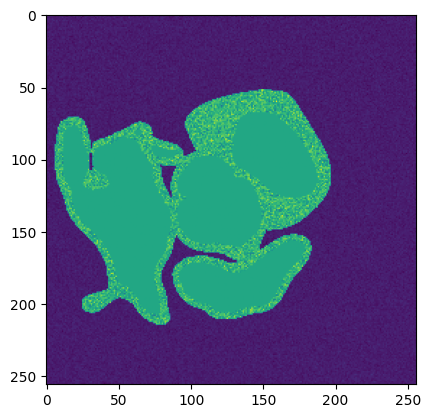

In [4]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [23]:
transducers = [transducer.Focused(max_frequency = 2e6,
                                  elements = 64, 
                                  width = 10e-3,
                                  height =  10e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/3,
                                  ray_num = 16, 
                                  imaging_ndims = 2,
                                  focus_azimuth = 50e-3,
                                  focus_elevation = 50e-3,
) for i in range(1)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

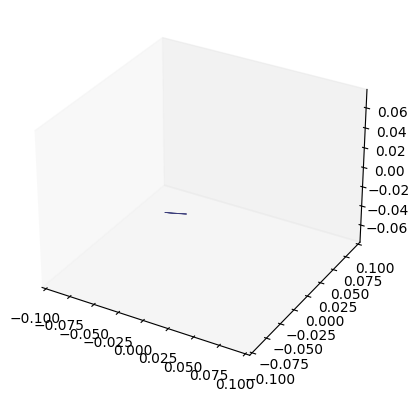

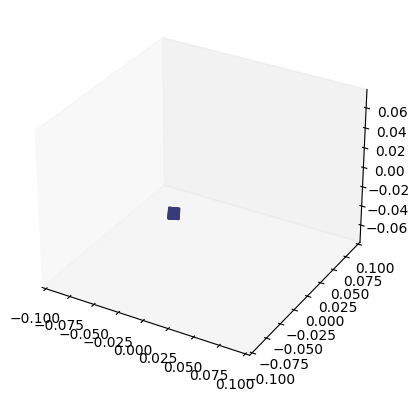

In [24]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.28,-np.pi*0.18,-np.pi*0.05], [-.055,0.04,-0.062]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*0.3,-np.pi*0.15,-np.pi*0.05], [-.06,0.06,-0.065]))

# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi*3/20,np.pi/6,0], [-0.07,0.03,0.05]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [25]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [26]:
simprops = simulation.SimProperties(
                grid_size   = (100e-3,40e-3,40e-3),
                voxel_size  = (0.1e-3,0.1e-3,0.1e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [27]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/cardiac_experiment_03',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

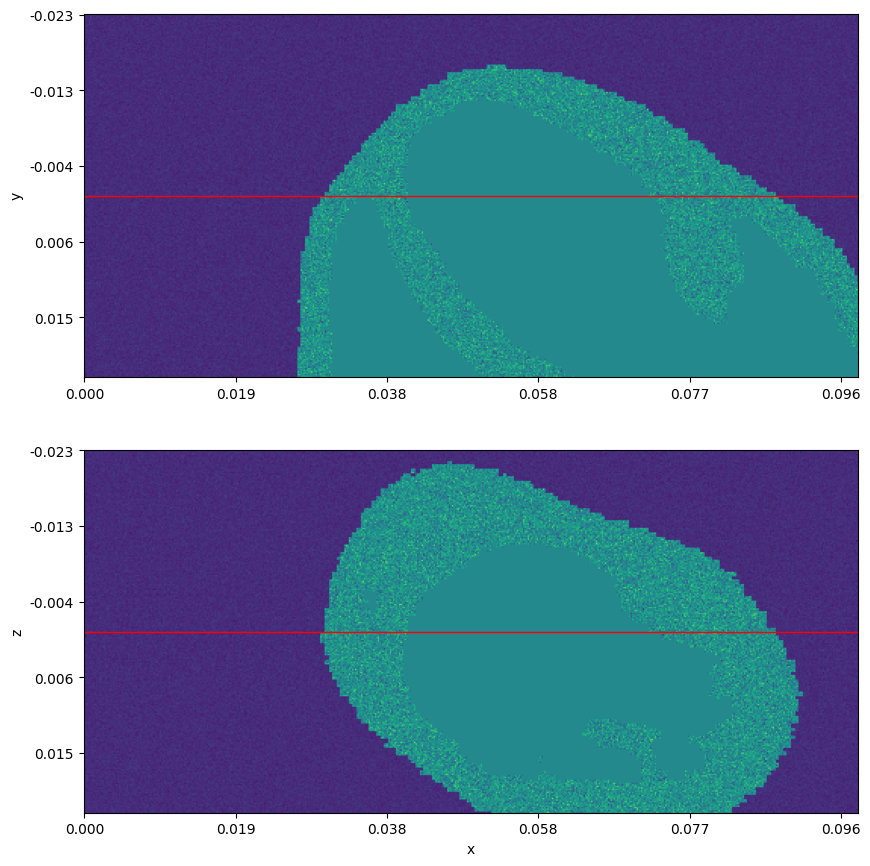

In [28]:
test_experiment.plot_ray_path(0)

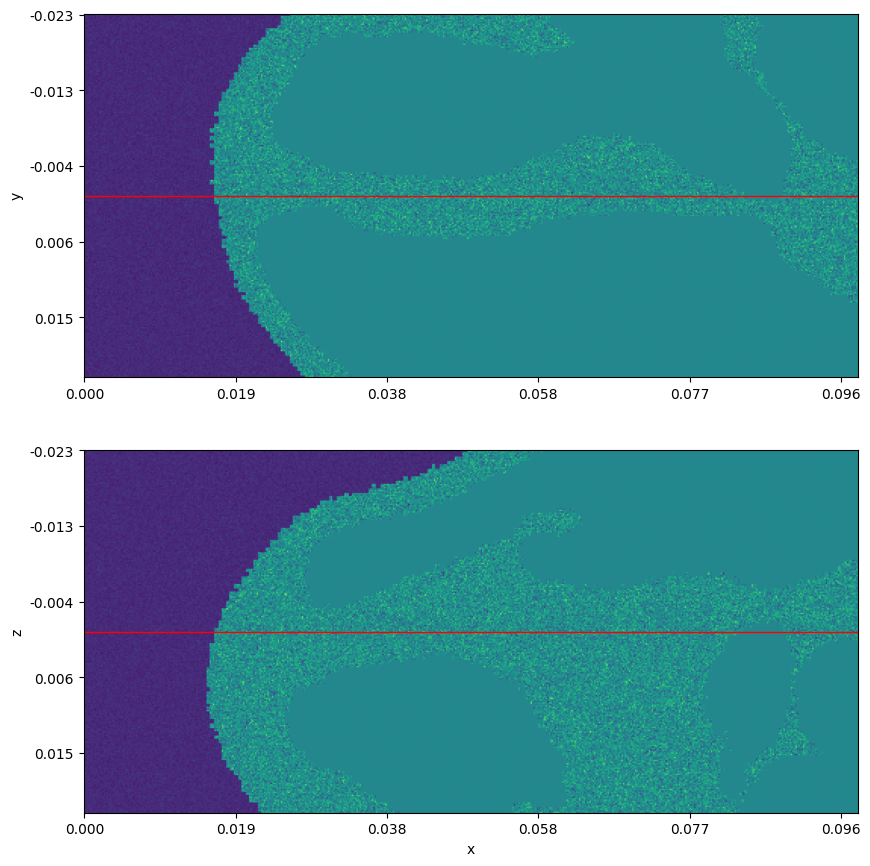

In [29]:
test_experiment.plot_ray_path(8)

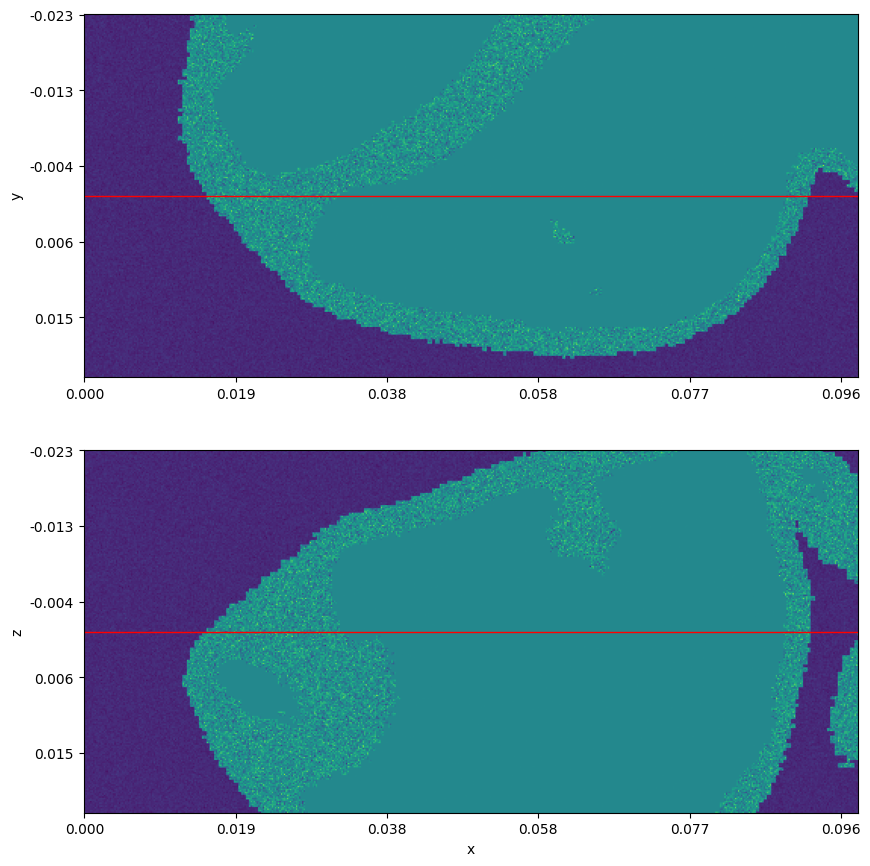

In [30]:
test_experiment.plot_ray_path(15)

In [17]:
test_experiment = experiment.Experiment.load('../experiment_files/cardiac_experiment_03')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (16), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


In [ ]:
test_experiment.run(repeat=True)

In [3]:
test_experiment.add_results()

In [4]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
# test_reconstruction.plot_ray_path(0)

In [ ]:
# test_reconstruction.plot_scatter()

In [5]:
image, signals = test_reconstruction.get_image(dimensions=2, downsample = 1, workers=1)

multiproc time 0.4612081050872803


100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


[]

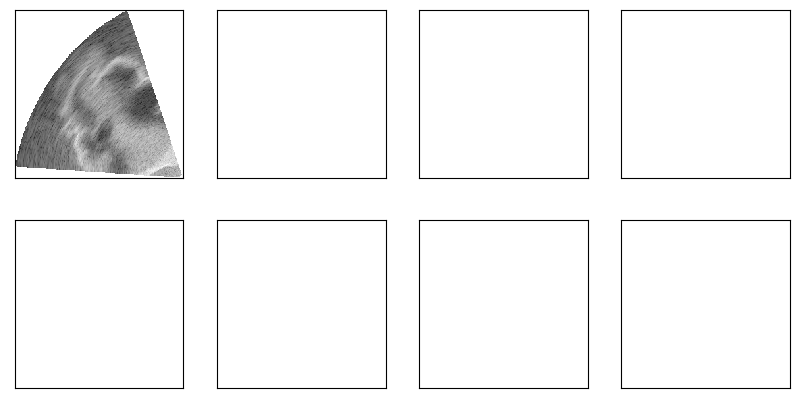

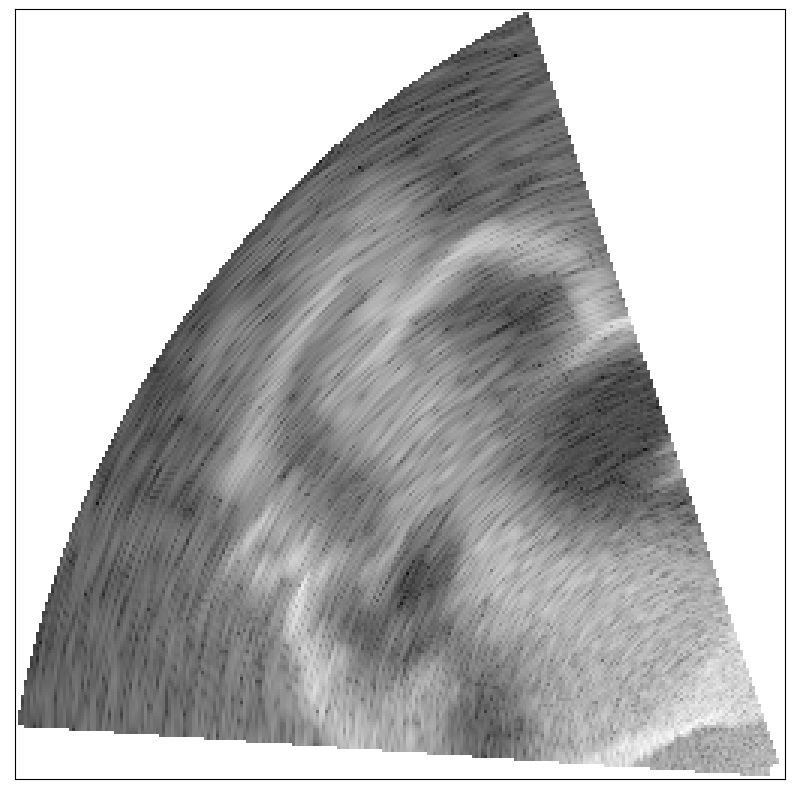

In [6]:
X = np.linspace(-1, 1, 256)
Y = np.linspace(-1, 1, 256)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(2,4, figsize=(10,5))
ax[0,0].pcolormesh(X, Y, signals[0], shading='auto', cmap='gray', norm='log')
# ax[0,1].pcolormesh(X, Y, signals[1], shading='auto', cmap='gray', norm='log')
# ax[0,2].pcolormesh(X, Y, signals[2], shading='auto', cmap='gray', norm='log')
# ax[0,3].pcolormesh(X, Y, signals[3], shading='auto', cmap='gray', norm='log')
# ax[1,0].pcolormesh(X, Y, signals[4], shading='auto', cmap='gray', norm='log')
# ax[1,1].pcolormesh(X, Y, signals[5], shading='auto', cmap='gray', norm='log')
# ax[1,2].pcolormesh(X, Y, signals[6], shading='auto', cmap='gray', norm='log')
# ax[1,3].pcolormesh(X, Y, signals[7], shading='auto', cmap='gray', norm='log')

for axd1 in ax:
    for a in axd1:
        a.set_aspect('equal')
        a.set_xticks([])
        a.set_yticks([])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.pcolormesh(X, Y, image, shading='auto', cmap='gray', norm='log')
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1, 1)
image_rays = np.stack([np.mean(test_experiment.results[i][1], axis=0)[100:] for i in range(len(test_experiment.results))])
ax.pcolor(np.log(image_rays + 2))

In [ ]:
im = test_reconstruction.results[0][2]

In [ ]:
im2 = im.reshape((1232,112,-1))

In [ ]:
plt.imshow(im2)

In [ ]:
im.shape

In [ ]:
plt.imshow(im[:,:,300].T, cmap='bwr')

In [ ]:
for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
    plt.imshow(im[:,:,frame], cmap='bwr')
    plt.colorbar()
    plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
    plt.close()